**Jacob Petty, Sardor Nodirov, and Saad Khan**

Spring 2026

CS 443: Bio-inspired Machine Learning

Project 1: Hebbian Learning

#### Week 2: Competitive Hebbian Network

This week you will implement a bio-inspired network that learns according to a competitive variant of Oja's Rule proposed by Krotov & Hopfield (2019). You will train this network on MNIST and CIFAR-10 while dynamically visualizing the learning process!


In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from image_datasets import get_dataset, train_val_split

plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-darkgrid'])
plt.show()
plt.rcParams.update({'font.size': 18})

np.set_printoptions(suppress=True, precision=3)

%load_ext autoreload
%autoreload 2

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if len(gpus) > 0:
    print('Running on the GPU')
else:
    print('NOT running on the GPU')

Running on the GPU


## Task 5: Building the Competitive Hebbian Network

Implement the Hebbian learning network in `hebb_net.py` and test it using the cells below.

As with your `LinearDecoder`, your Competitive Hebbian network should be implemented entirely using the low-level TensorFlow API. 

In [4]:
from hebb_net import HebbNet

### 5a. Start implementing Hebbian network (`HebbNet` class)

Implement the following methods in `hebb_net.py`:
- Constructor
- `get_wts(self)`
- `set_wts(self, wts)`
- `net_in(self, x)`

The network uses the usual Dense net in:

$$\text{netIn}_{ih} = z_{ih} = \sum_{j=1}^M x_{ij} w_{jh}$$


#### Test: `net_in`

In [5]:
N, M, H = 3, 10, 6
tf.random.set_seed(0)
x = tf.random.uniform(shape=(N, M), seed=0)

net = HebbNet(M, H, k=3)
print(f'Your net_in is:\n{net.net_in(x)}\nand it should be:')
print('''[[ 1.232 -0.955  2.153  2.175 -3.539 -0.031]
 [ 1.957  0.084  1.141 -0.243 -3.882 -1.126]
 [ 2.25  -0.947  0.124 -0.15  -5.327 -1.171]]''')

I0000 00:00:1771556566.798435 5832385 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1771556566.798500 5832385 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Initialized wts randomly.
Your net_in is:
[[ 1.232 -0.955  2.153  2.175 -3.539 -0.031]
 [ 1.957  0.084  1.141 -0.243 -3.882 -1.126]
 [ 2.25  -0.947  0.124 -0.15  -5.327 -1.171]]
and it should be:
[[ 1.232 -0.955  2.153  2.175 -3.539 -0.031]
 [ 1.957  0.084  1.141 -0.243 -3.882 -1.126]
 [ 2.25  -0.947  0.124 -0.15  -5.327 -1.171]]


### 5b. Preparation for implementing Hebbian activation

This is a multi-part task is geared toward discovering and practicing TensorFlow operations that will guide you through the implementation of the Hebbian network activation function.

#### (i) Find the index of the top-k items in each row of a Tensor

Here is a mock scenario for this task (not specifically related to `HebbNet`). We want to find the index of the 2nd largest item in each row of a tensor. While in this case we are interested in the `k=2` largest, your solution should in theory work for any `k`. This is like `argmax` within each row, but more configurable. We may want the index of the max (`k=1`), the 2nd largest (`k=2`), 3rd largest (`k=3`), and so forth. If there are ties for `k`-th place, the smallest column index is fine.

Ultimately, we want the column indices to have a `tf.int32` data type.

**Hint:** There is a hint in the title of this subtask...

In [6]:
tf.random.set_seed(2)
my_tensor = tf.cast(tf.math.round(10*tf.random.uniform(maxval=10, shape=(7, 4)))/10, dtype=tf.float32)

col_indices = tf.math.top_k(my_tensor, k=2).indices[:, 1]

print(f'my_tensor is:\n{my_tensor}')
print(f'Column indices shape is {col_indices.shape} and should be (7,).')
print(f'Column indices of the 2nd largest values in each row are:\n{col_indices}')
print('They should be\n[3 0 2 3 2 2 0]')
print(f"Dtype is {col_indices.dtype} as it should be <dtype: 'int32'>")



my_tensor is:
[[ 1.5  4.6  2.2  3.5]
 [ 9.9 10.   5.6  1.6]
 [ 9.9  6.8  9.4  7.6]
 [ 8.6  4.3  3.9  7. ]
 [ 6.5  0.8  3.7  0.6]
 [ 9.7  1.   4.   1.7]
 [ 8.5  6.4  9.   7.1]]
Column indices shape is (7,) and should be (7,).
Column indices of the 2nd largest values in each row are:
[3 0 2 3 2 2 0]
They should be
[3 0 2 3 2 2 0]
Dtype is <dtype: 'int32'> as it should be <dtype: 'int32'>


#### (ii) Generating sequences of values

Generate a 1D Tensor of `tf.int32` values that go from 0 to the number of rows in `my_tensor` - 1, in steps of 1. 

In [7]:
row_indices = tf.range(tf.shape(my_tensor)[0], dtype=tf.int32)
print(f'Row indices shape is {row_indices.shape} and should be (7,).')
print(f'Your row indices are:\n{row_indices}')
print('They should be\n[0 1 2 3 4 5 6]')
print(f"Dtype is {row_indices.dtype} as it should be <dtype: 'int32'>")

Row indices shape is (7,) and should be (7,).
Your row indices are:
[0 1 2 3 4 5 6]
They should be
[0 1 2 3 4 5 6]
Dtype is <dtype: 'int32'> as it should be <dtype: 'int32'>


#### (iii) Stacking multiple Tensors together

Now you have a list of row indices (`row_indices`) and a list of column indices (`col_indices`). Write code to stack them into a single Tensor where the first column holds the row indices and the second column holds the column indices. In other words, we are creating row-col index pairs in each row.

Example:
`rows: [0, 1, 2]`
`cols: [9, 8, 7]`

We want combined:
```
0, 9
1, 8
2, 7
```

In [8]:
rc_indices = tf.stack([row_indices, col_indices], axis=1)
print(f'Rows are: {row_indices}')
print(f'Cols are: {col_indices}')
print(f'Your combined Tensor is:\n{rc_indices} and it should be:')
print('''[[0 3]
 [1 0]
 [2 2]
 [3 3]
 [4 2]
 [5 2]
 [6 0]]''')


Rows are: [0 1 2 3 4 5 6]
Cols are: [3 0 2 3 2 2 0]
Your combined Tensor is:
[[0 3]
 [1 0]
 [2 2]
 [3 3]
 [4 2]
 [5 2]
 [6 0]] and it should be:
[[0 3]
 [1 0]
 [2 2]
 [3 3]
 [4 2]
 [5 2]
 [6 0]]


#### (iv) Creating a mask in TensorFlow

Let's say we want to create a Tensor of all 0s, except have some constant value at the locations of the 2nd largest items you found above in `my_tensor`. This Tensor should have the same shape as `my_tensor`. Let's make that constant value `99` here. Figure out how to use the TensorFlow function [scatter_nd](https://www.tensorflow.org/api_docs/python/tf/scatter_nd) to accomplish this.

*Creating a Tensor that is the same shape as the original Tensor with all 0s except at preset locations is called a **mask**.*

In [9]:
mask_tensor = tf.scatter_nd(rc_indices, tf.fill(tf.shape(rc_indices)[0], 99), tf.shape(my_tensor))

print(f'updated tensor is:\n{mask_tensor} and should be:')
print('''[[ 0  0  0 99]
 [99  0  0  0]
 [ 0  0 99  0]
 [ 0  0  0 99]
 [ 0  0 99  0]
 [ 0  0 99  0]
 [99  0  0  0]]''')
print(f'Column indices of the 2nd largest values in each row are:\n{tf.squeeze(col_indices)}')
print('They should be\n[3 0 2 3 2 2 0]')
print(f"Dtype is {col_indices.dtype} as it should be <dtype: 'int32'>")



updated tensor is:
[[ 0  0  0 99]
 [99  0  0  0]
 [ 0  0 99  0]
 [ 0  0  0 99]
 [ 0  0 99  0]
 [ 0  0 99  0]
 [99  0  0  0]] and should be:
[[ 0  0  0 99]
 [99  0  0  0]
 [ 0  0 99  0]
 [ 0  0  0 99]
 [ 0  0 99  0]
 [ 0  0 99  0]
 [99  0  0  0]]
Column indices of the 2nd largest values in each row are:
[3 0 2 3 2 2 0]
They should be
[3 0 2 3 2 2 0]
Dtype is <dtype: 'int32'> as it should be <dtype: 'int32'>


### 5c. Hebbian network activation

Now you are ready to implement the Hebbian network activation (`net_act` method)!

The activation in the Hebbian network (`net_act`) to each sample $i$ in neuron $h$ implements a **competitive** process:

$$\text{netAct}_{ih} = f(z_{ih})  =
\begin{cases}
      1, & \text{if}\ h = argmax_h (\text{netIn}_{ih}) \text{ i.e neuron } h \text{ comes in 1st place} \\
      -\Delta, & \text{if neuron }\ h \text{ comes in } k^{\text{th}} \text{ place} \\
      0, & \text{otherwise}
\end{cases}$$

Notes about the above netAct equation:

- "1st place" refer to the neuron that achieves the highest netIn values.
- "$k^{\text{th}}$ place" refers to the neuron that achieves the $k^{\text{th}}$ highest netIn value. For example, $k=2$ refers to the "2nd place" neuron that achieves the 2nd highest netIn.
- $k^{\text{th}}$ place is defined in the usual "human-interpretable" rather than an "Python indexing" sense (i.e. $k=2$ for second place, $k=3$ for third place, etc.)

Implement the neural competition in the `net_act(self, net_in)` method then test it below.

#### Test: net_act

In [10]:
def test_net_act(x, M, H, kth_place_inhibited, inhib_value):
    '''net_act tester function'''
    tf.random.set_seed(9)
    net = HebbNet(M, H, k=kth_place_inhibited, inhib_value=inhib_value)
    net_in = net.net_in(x)
    print(f"The net_in is:\n{net_in}:")
    print(f'So your net_act is:\n{net.net_act(net_in)}\nand it should be:')

In [11]:
# Simplest test
print('Test 1: Simplest test with 1 sample and no inhibition (only winner-take-all)')
x = np.array([[1, 2, 0]])
test_net_act(x, M=3, H=5, kth_place_inhibited=2, inhib_value=0)
print('[[0. 1. 0. 0. 0.]]')

Test 1: Simplest test with 1 sample and no inhibition (only winner-take-all)
Initialized wts randomly.
The net_in is:
[[-1.464  1.609  0.766 -0.849  0.427]]:
So your net_act is:
[[0. 1. 0. 0. 0.]]
and it should be:
[[0. 1. 0. 0. 0.]]


In [12]:
# Test with additional samples
print(70*'-')
print('Test 2: 3 samples and no inhibition (only winner-take-all)')
x = np.array([[0, 1, 2], [1, 0, 1], [10, 1, 0]])
test_net_act(x, M=3, H=5, kth_place_inhibited=2, inhib_value=0)
print('''[[0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]]''')

print(70*'-')
print('Test 3: This should still work — 3 samples and no inhibition targeting winner (still only winner-take-all)')
x = np.array([[0, 1, 2], [1, 0, 1], [10, 1, 0]])
test_net_act(x, M=3, H=5, kth_place_inhibited=1, inhib_value=0)
print('''[[0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]]''')

----------------------------------------------------------------------
Test 2: 3 samples and no inhibition (only winner-take-all)
Initialized wts randomly.
The net_in is:
[[  0.801   0.835   1.712   1.813  -0.401]
 [ -0.774   0.094   1.719   1.048   1.03 ]
 [-12.44    1.404   8.395  -0.957  10.377]]:
So your net_act is:
[[0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]]
and it should be:
[[0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]]
----------------------------------------------------------------------
Test 3: This should still work — 3 samples and no inhibition targeting winner (still only winner-take-all)
Initialized wts randomly.
The net_in is:
[[  0.801   0.835   1.712   1.813  -0.401]
 [ -0.774   0.094   1.719   1.048   1.03 ]
 [-12.44    1.404   8.395  -0.957  10.377]]:
So your net_act is:
[[0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]]
and it should be:
[[0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]]


In [13]:
# Tests with 2nd place inhibited
print('Test 4: Test with 1 sample, 2nd place inhibited')
x = np.array([[1, 2, 0]])
test_net_act(x, M=3, H=5, kth_place_inhibited=2, inhib_value=-0.5)
print('[[ 0.   1.  -0.5  0.   0. ]]')

print(70*'-')
print('Test 5: 3 samples, 2nd place inhibited')
x = np.array([[0, 1, 2], [1, 0, 1], [10, 1, 0]])
test_net_act(x, M=3, H=5, kth_place_inhibited=2, inhib_value=-0.5)
print('''[[ 0.   0.  -0.5  1.   0. ]
 [ 0.   0.   1.  -0.5  0. ]
 [ 0.   0.  -0.5  0.   1. ]]''')

Test 4: Test with 1 sample, 2nd place inhibited
Initialized wts randomly.
The net_in is:
[[-1.464  1.609  0.766 -0.849  0.427]]:
So your net_act is:
[[ 0.   1.  -0.5  0.   0. ]]
and it should be:
[[ 0.   1.  -0.5  0.   0. ]]
----------------------------------------------------------------------
Test 5: 3 samples, 2nd place inhibited
Initialized wts randomly.
The net_in is:
[[  0.801   0.835   1.712   1.813  -0.401]
 [ -0.774   0.094   1.719   1.048   1.03 ]
 [-12.44    1.404   8.395  -0.957  10.377]]:
So your net_act is:
[[ 0.   0.  -0.5  1.   0. ]
 [ 0.   0.   1.  -0.5  0. ]
 [ 0.   0.  -0.5  0.   1. ]]
and it should be:
[[ 0.   0.  -0.5  1.   0. ]
 [ 0.   0.   1.  -0.5  0. ]
 [ 0.   0.  -0.5  0.   1. ]]


In [14]:
# Tests with 4th place inhibited
print('Test 6: Test with 3 samples, 4th place inhibited')
x = np.array([[0, 1, 2], [1, 0, 1], [10, 1, 0]])
test_net_act(x, M=3, H=5, kth_place_inhibited=4, inhib_value=-0.25)
print('''[[-0.25  0.    0.    1.    0.  ]
 [ 0.   -0.25  1.    0.    0.  ]
 [ 0.    0.    0.   -0.25  1.  ]]''')

Test 6: Test with 3 samples, 4th place inhibited
Initialized wts randomly.
The net_in is:
[[  0.801   0.835   1.712   1.813  -0.401]
 [ -0.774   0.094   1.719   1.048   1.03 ]
 [-12.44    1.404   8.395  -0.957  10.377]]:
So your net_act is:
[[-0.25  0.    0.    1.    0.  ]
 [ 0.   -0.25  1.    0.    0.  ]
 [ 0.    0.    0.   -0.25  1.  ]]
and it should be:
[[-0.25  0.    0.    1.    0.  ]
 [ 0.   -0.25  1.    0.    0.  ]
 [ 0.    0.    0.   -0.25  1.  ]]


### 5d. Hebbian weight update

The competitive Hebbian network uses the Competitive Oja's Rule for weight updates. The first part is computing the weight change:

$$
\Delta \text{w}_{jh} = \sum_{i=1}^Bx_{ij}\text{netAct}_{ih} - w_{jh}\sum_{i=1}^B\text{netIn}_{ih}\text{netAct}_{ih}
$$

The second part is actually updating the weights with the weight change:
$$
w_{jh}(t) = w_{jh}(t-1) + \eta \frac{\Delta \text{w}_{jh}}{\max{|\text{w}|} + \epsilon} 
$$

where $\max{| \text{w}|}$ is the absolute value of the maximum of all the `(M, H)` current weights (a float) and $\epsilon$ is a small positive number to prevent possible division by 0.

Implement the neural competition in the `update_wts(self, x, net_in, net_act, lr, eps=1e-10)` method then test it below.

#### Test: `update_wts`

In [15]:
N, M, H = 3, 10, 6

tf.random.set_seed(0)
x = tf.random.uniform(shape=(N, M))

net = HebbNet(M, H, k=3)
net_in = net.net_in(x)
net_act = net.net_act(net_in)
net.update_wts(x, net_in, net_act, lr=0.5)
print(f'Your wts after 1 update are:\n{net.get_wts()}\nand it should be:')
print('''[[ 0.928 -0.059 -0.531  0.092 -0.178 -0.919]
 [-2.052 -2.894  0.803 -0.931 -0.372 -0.321]
 [-2.775 -2.993 -0.524  2.044 -1.503 -0.921]
 [ 1.462 -1.516 -0.133  0.09  -1.964 -1.298]
 [-0.232 -1.578 -0.48   0.049  0.725 -0.216]
 [-1.219  1.166 -1.384 -0.897 -0.05   0.696]
 [ 0.028 -2.214  0.679  0.963 -0.197  0.157]
 [-0.031  1.126 -1.05  -0.434 -1.022 -0.165]
 [ 2.195 -0.087  0.121  0.095 -0.482  0.056]
 [ 0.078 -2.283  0.027 -0.676  0.146 -0.822]]''')

Initialized wts randomly.
Your wts after 1 update are:
[[ 0.928 -0.059 -0.531  0.092 -0.178 -0.919]
 [-2.052 -2.894  0.803 -0.931 -0.372 -0.321]
 [-2.775 -2.993 -0.524  2.044 -1.503 -0.921]
 [ 1.462 -1.516 -0.133  0.09  -1.964 -1.298]
 [-0.232 -1.578 -0.48   0.049  0.725 -0.216]
 [-1.219  1.166 -1.384 -0.897 -0.05   0.696]
 [ 0.028 -2.214  0.679  0.963 -0.197  0.157]
 [-0.031  1.126 -1.05  -0.434 -1.022 -0.165]
 [ 2.195 -0.087  0.121  0.095 -0.482  0.056]
 [ 0.078 -2.283  0.027 -0.676  0.146 -0.822]]
and it should be:
[[ 0.928 -0.059 -0.531  0.092 -0.178 -0.919]
 [-2.052 -2.894  0.803 -0.931 -0.372 -0.321]
 [-2.775 -2.993 -0.524  2.044 -1.503 -0.921]
 [ 1.462 -1.516 -0.133  0.09  -1.964 -1.298]
 [-0.232 -1.578 -0.48   0.049  0.725 -0.216]
 [-1.219  1.166 -1.384 -0.897 -0.05   0.696]
 [ 0.028 -2.214  0.679  0.963 -0.197  0.157]
 [-0.031  1.126 -1.05  -0.434 -1.022 -0.165]
 [ 2.195 -0.087  0.121  0.095 -0.482  0.056]
 [ 0.078 -2.283  0.027 -0.676  0.146 -0.822]]


## Task 6: Train the Competitive Hebbian Network

### 6a. Implement `fit` and train Hebbian network on MNIST

Now is the time to train your Hebbian network on the MNIST training set! Implement the `fit` method and train your Hebbian network with the below hyperparameters. Given the high computational demands, you will want to train your Hebbian network using a GPU.

#### Goal

The goal is to train the Hebbian network so that the netAct values provide an accurate encoding of the MNIST digits. Once the network weights enable this (after the training that you do in this task), next week you will train your neural networks to decode the class label from the Hebbian network netAct values.

#### Live plotting/animation

You will want to set `plot_wts_live`: set to True so that you can visualize the weights dynamically during training every `print_every` epochs! It's really cool to see the learning process in action and it's also a great debugging tool! 

You will want to get this working — it is worth it!

#### Hyperparameters

- Train on the Hebbian network with the full, **centered** 60,000 samples from the training set. Do not create a validation set here. *Since we create the validation set from the training set, training the Hebbian network on the full 60k training set samples will set us up for training the decoder networks with a validation set next week.*
- 500 epochs
- 2000 neurons
- 512 sample mini-batch size
- $k = 6$ neurons that achieve the 6th highest netIn should be inhibited to $-\Delta$
- $\Delta = 0.4$
- `5e-3` learning rate

#### Tips
- If your dynamic weight plots (after epoch 0) look mostly white with some red streaks, try transposing your weight matrix before passing it into `draw_grid_image`!
- Make sure you pass in the correct feature shape into `fit`.
- Your weights should range from (roughly) (-0.5, +0.5) by the end of the training session.
- **I highly recommend saving the network weights if your network once training is done in `fit` (the default). This will save you a lot of time next week when working with the decoder neural networks.** 
- Training is expected to take ~10-15 mins on a GPU.

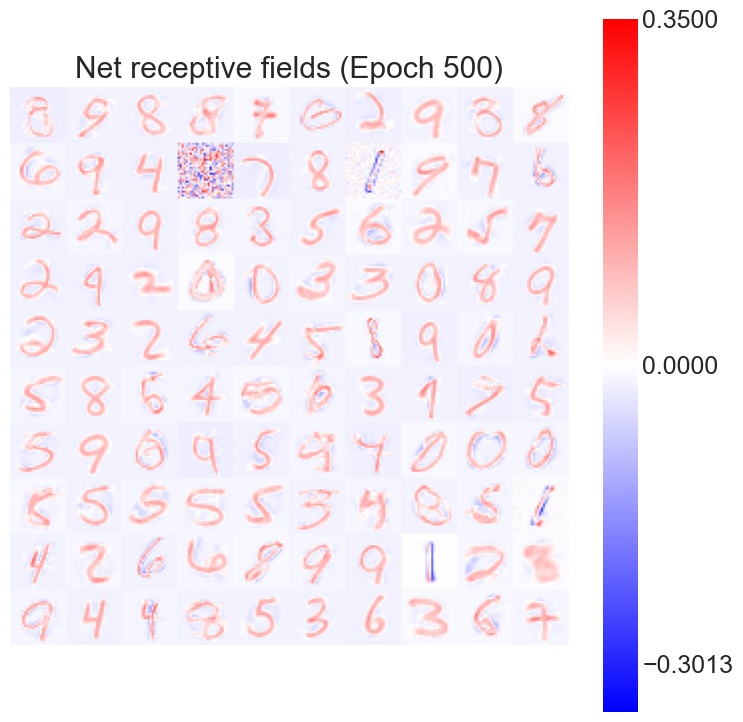

Saving weights...Done!


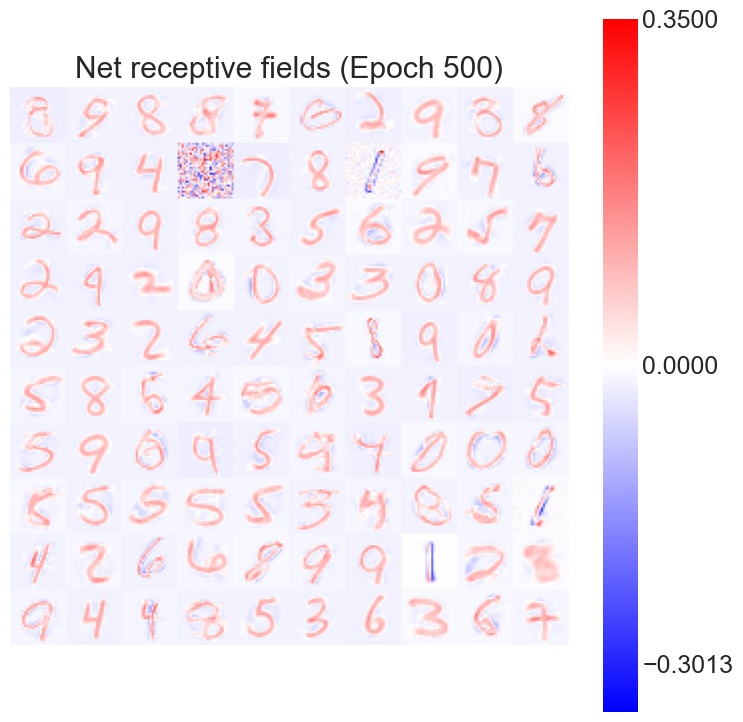

In [17]:
x_train, y_train, x_test, y_test = get_dataset('mnist', norm_method='center', flatten=True)

M = x_train.shape[1]
hebb_net_mnist = HebbNet(M, 2000, k=6, inhib_value=-0.4, saved_wts_path='weights/mnist_wts.npy')

hebb_net_mnist.fit(x_train, epochs=500, mini_batch_sz=512, lr=5e-3,
                   plot_wts_live=True, print_every=1, save_wts=True,
                   ds_feat_shape=(28, 28, 1))

### 6b. Plot final Competitive Hebbian network weights (MNIST)

Use `draw_grid_image` to create a plot of the weights of 100 neurons (e.g. in a 10x10 grid).

In [18]:
from viz import draw_grid_image

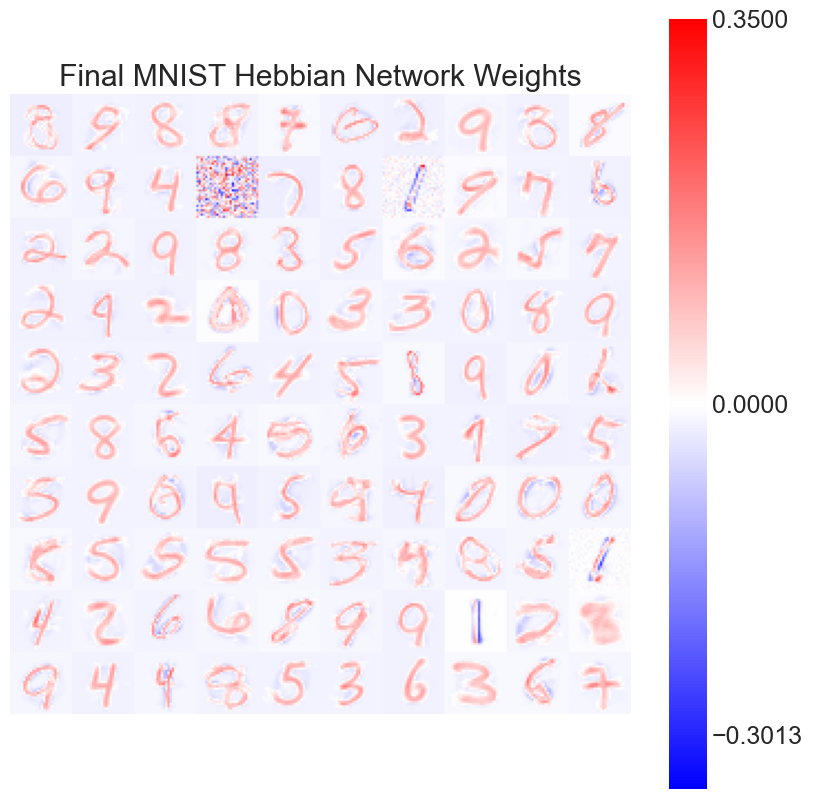

In [19]:
plt.figure(figsize=(10, 10))
draw_grid_image(tf.transpose(hebb_net_mnist.get_wts()), 10, 10,
                title='Final MNIST Hebbian Network Weights',
                sample_dims=(28, 28, 1))

### 6c. Questions

**Question 4:** Do the network weights exactly match specific samples in the dataset? Why or why not?

**Question 5:** Interpret the meaning of the positive and negative values within the same neuron's weights. How do these factors affect processing? It might be helpful to refer to specific example(s) in your visualization.

**Question 6:** Train your network when the competition is "winner-take-all" — the winner gets activation 1 and every other neuron gets activation 0. Generate a plot of the weights to showcase what you find. How are they qualitatively different from before? *You shouldn't need to train for long to see the difference.*

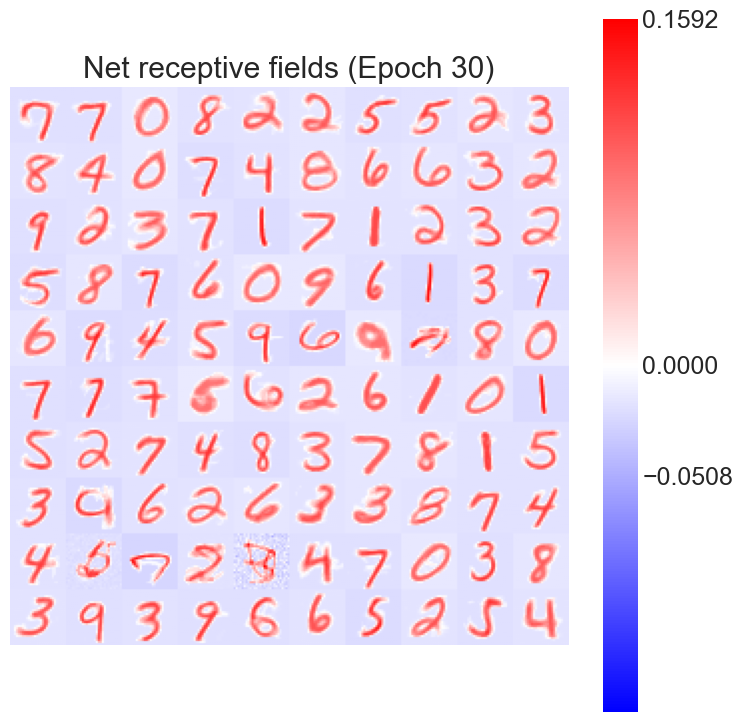

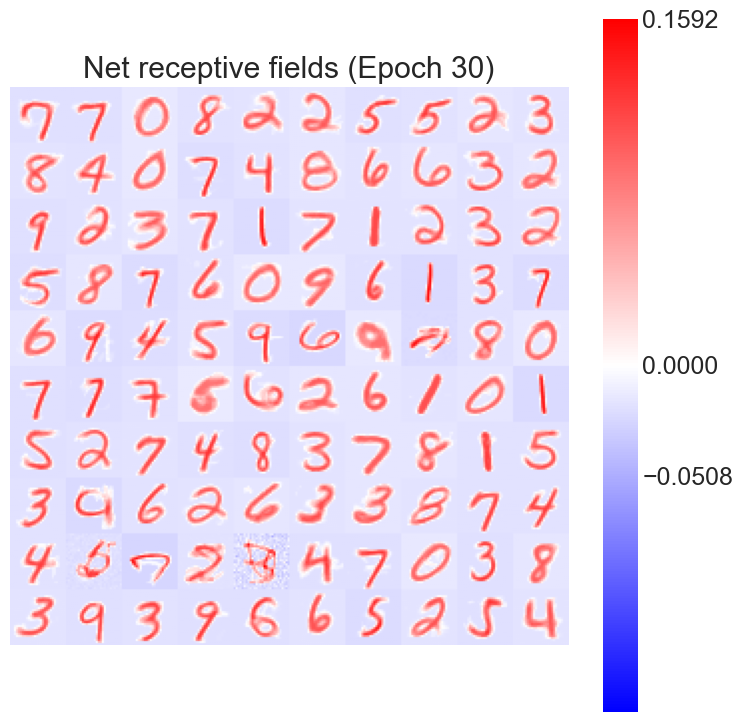

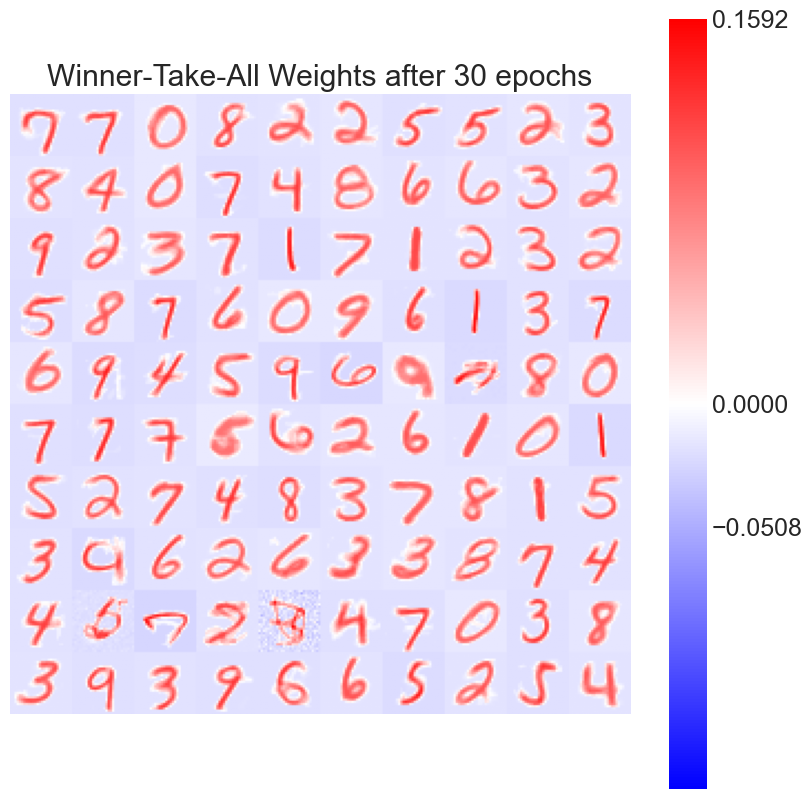

In [21]:
# Question 6: Winner-take-all
M_wta = x_train.shape[1]
hebb_net_wta = HebbNet(M_wta, 2000, k=1, inhib_value=0.0)

hebb_net_wta.fit(x_train, epochs=30, mini_batch_sz=512, lr=5e-3,
                 plot_wts_live=True, print_every=5, save_wts=False,
                 ds_feat_shape=(28, 28, 1))

plt.figure(figsize=(10, 10))
draw_grid_image(tf.transpose(hebb_net_wta.get_wts()), 10, 10,
                title='Winner-Take-All Weights after 30 epochs',
                sample_dims=(28, 28, 1))

**Answer 4:** No, the weights above do not exactly match the samples in the dataset. These look quite blurry with some having major artifacts, akin to diffusion-based image generation. The red lines are also very pale and we can see blue "shadows" next to some weight visualizations. The reason for this difference is that these weights are the internal representation of the digits that the model has learned, or averaged patterns (wide strokes) of how different digits can be written. I'd like to liken it to a "creepy averaged face" we got when we visualized the weights of a face detection model in CS251 (if I remember correctly).

**Answer 5:** The red color visualizes the positive values when the model pays attention to to select FOR the specific digit. The blue color (negative values) serves the opposite job; it's where the model looks at to select AGAINST similarly shaped digits. For example, in many examples with the digit 5, we can see the general red outline (template) the model referenced to predict 5 and we can see a slight blue line that closing the 5's circle (almost turning it into 6). This is largely how the model differentiated 5 from 6. A blue line is a negative test, if it the neuron were to be activated there, it'd be 6, without activation, it's 5. 

**Answer 6:** In the winner-take-all plot, the digits look bolder, with no negative values and less artifacts. The model learned a few versions of the digits really well and is confident. However, that comes at a detriment of diversity of patterns. For example, I noticed that the first plot had a few different ways to write 2 (with and without the little loop), but in the second plot, we can only see the 2s with the loop. I'm afraid the model now might perform poorly when presented a 2 without the loop.

### 6d. Train the Hebbian network on CIFAR-10

Repeat what you did above, but this time for CIFAR-10.

#### Hyperparameters

I suggest using the same hyperparameters that you used for MNIST, except for the following:

- 250 epochs
- $k = 2$ neurons that achieve the 2nd highest netIn should be inhibited to $-\Delta$
- `5e-4` learning rate

**Notes:**
- Use the centered version of CIFAR-10, as you did for MNIST.
- The training time on the GPU should we similar to that required by MNIST.
- The weight visualization is neat and should be quite different from what you observed MNIST.
- **Use a different name for the weights that get exported. You do NOT want to overwrite your "good" MNIST weights!**

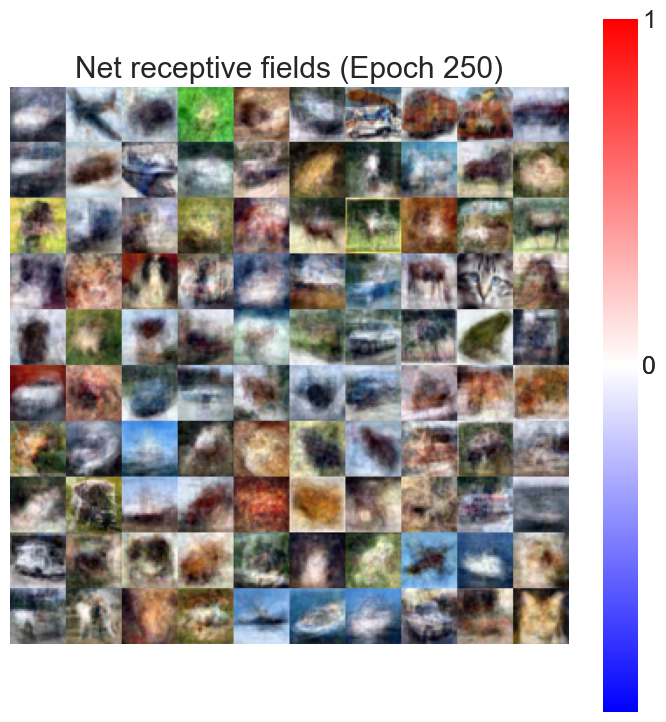

Saving weights...Done!


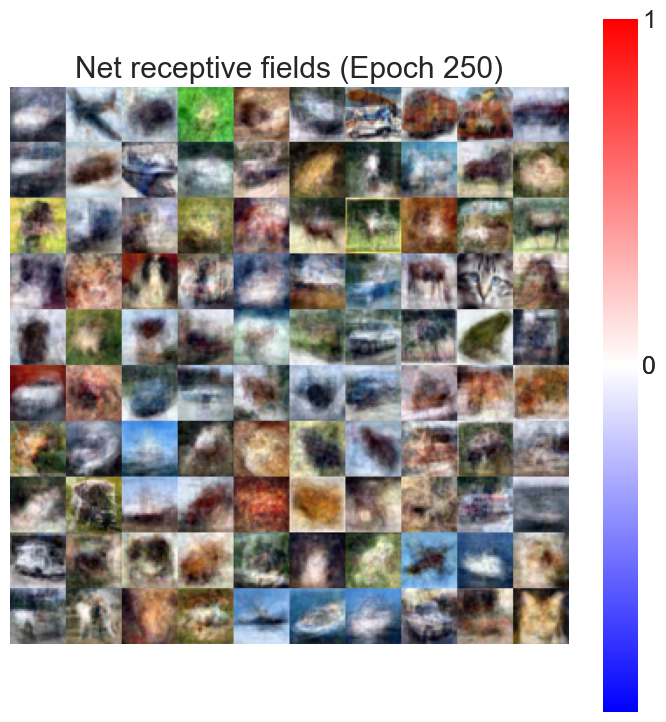

In [ ]:
x_train_c, y_train_c, x_test_c, y_test_c = get_dataset('cifar10', norm_method='center', flatten=True)

M_c = x_train_c.shape[1]
hebb_net_cifar = HebbNet(M_c, 2000, k=2, inhib_value=-0.4, saved_wts_path='weights/cifar10_wts.npy')

hebb_net_cifar.fit(x_train_c, epochs=250, mini_batch_sz=512, lr=5e-4,
                   plot_wts_live=True, print_every=1, save_wts=True,
                   ds_feat_shape=(32, 32, 3))

### 6e. Questions

**Question 7:** Make a plot showing the final weights of 100 neurons in a 10x10 grid. What do you glean about what the neurons learn to encode about the CIFAR-10 dataset? 

**Question 8:** To what extent are characteristics of the encoding similar or different to what you obtained with MNIST?

**Question 9:** Copy your code to train the competitive Hebbian network on CIFAR-10 below and make the following changes:
- Turn off the live visualization.
- When you call `fit`, set `save_wts` to `False` (**do NOT overwrite your "good" CIFAR-10 weights!**).
- Lower the number of epochs to something in the range 5-15.

Use the `time` module to time how long the training session takes both on the CPU and on the GPU (two different training sessions). Which is faster and by how large of a margin?

**Answer 7:** I'm quite impressed by how well the model learned the overall patterns of one object or another. I can semi-clearly see the shapes of the planes, boats, animals and cars. The model learned the colors, especially the background, of the object very well: with animals mostly having green backgrounds, planes on a light blue sky and cars on a greyish road. Interestingly, it also learned that most cat photos are taken up-close.

**Answer 8:** I don't see the activation (or attention) values in the weights. These actually look very close to what might be inside the CIFAR-10 dataset as individual samples. For example, a weight representation on the 4th row and -2th column looks like a low-res standalone photo taken of a grey cat with blue eyes.

**Answer 9:** On my Macbook Pro with M4 Pro, a GPU gave almost a 3x boost in training speed, with 8.12s (GPU) against 24.21 on a CPU.

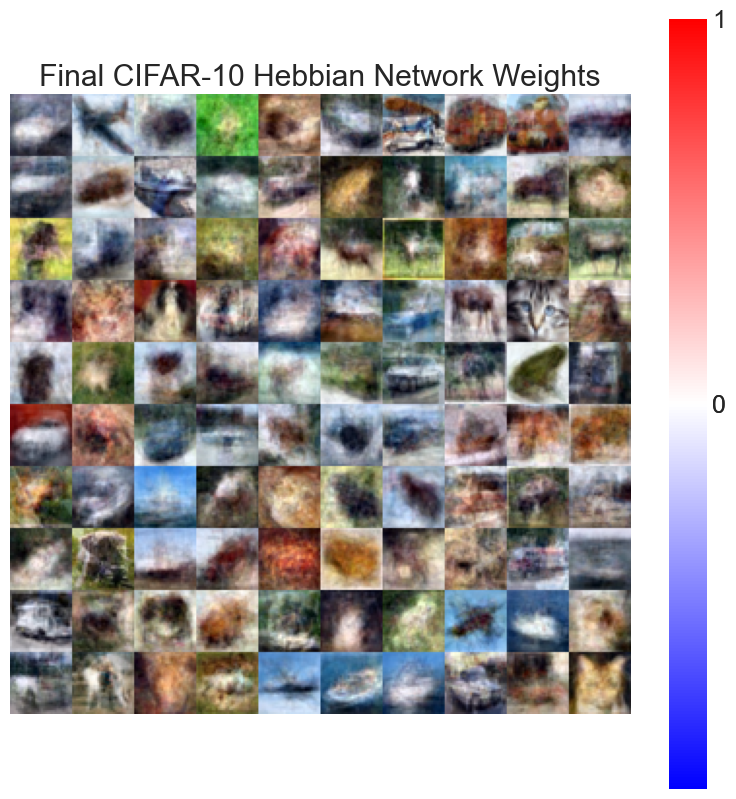

In [ ]:
plt.figure(figsize=(10, 10))
draw_grid_image(tf.transpose(hebb_net_cifar.get_wts()), 10, 10,
                title='Final CIFAR-10 Hebbian Network Weights',
                sample_dims=(32, 32, 3))

In [24]:
# GPU timing
M_c = x_train_c.shape[1]
hebb_net_gpu = HebbNet(M_c, 2000, k=2, inhib_value=-0.4)

start_gpu = time.time()
with tf.device('/GPU:0'):
    hebb_net_gpu.fit(x_train_c, epochs=10, mini_batch_sz=512, lr=5e-4,
                     plot_wts_live=False, save_wts=False,
                     ds_feat_shape=(32, 32, 3))
end_gpu = time.time()
gpu_time = end_gpu - start_gpu
print(f'GPU training time: {gpu_time:.2f} seconds')

Initialized wts randomly.
Starting epoch 1/10
Starting epoch 2/10
Starting epoch 3/10
Starting epoch 4/10
Starting epoch 5/10
Starting epoch 6/10
Starting epoch 7/10
Starting epoch 8/10
Starting epoch 9/10
Starting epoch 10/10
GPU training time: 8.12 seconds


In [25]:
# CPU timing
hebb_net_cpu = HebbNet(M_c, 2000, k=2, inhib_value=-0.4)

start_cpu = time.time()
with tf.device('/CPU:0'):
    hebb_net_cpu.fit(x_train_c, epochs=10, mini_batch_sz=512, lr=5e-4,
                     plot_wts_live=False, save_wts=False,
                     ds_feat_shape=(32, 32, 3))
end_cpu = time.time()
cpu_time = end_cpu - start_cpu
print(f'CPU training time: {cpu_time:.2f} seconds')
print(f'GPU training time: {gpu_time:.2f} seconds')
print(f'Speedup: {cpu_time / gpu_time:.2f}x')

Initialized wts randomly.
Starting epoch 1/10
Starting epoch 2/10
Starting epoch 3/10
Starting epoch 4/10
Starting epoch 5/10
Starting epoch 6/10
Starting epoch 7/10
Starting epoch 8/10
Starting epoch 9/10
Starting epoch 10/10
CPU training time: 24.21 seconds
GPU training time: 8.12 seconds
Speedup: 2.98x
